# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [32]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [33]:
!pip install pymongo[srv]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [34]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [35]:
!pip install tweepy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [36]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [64]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [65]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [66]:
client = MongoClient(mongod_connect)
db = client.gp8 # use or create a database named demo
tweet_collection = db.tweet_collection #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [61]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [62]:
track = ['COVID19'] # define the keywords, tweets contain election

#locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [63]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

AttributeError: module 'tweepy' has no attribute 'StreamListener'

## Use the REST API to Collect Tweets

Authorize the REST API 

In [67]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [68]:
count = 100 #number of returned tweets, default and max is 100
geocode = "44.3148,-85.6024,100mi"  # defin the location, in Harrisonburg, VA
q = "COVID19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [69]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [70]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [71]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

12863
6685


Create a text index and print the Tweets containing specific keywords. 

In [50]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [51]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "COVID19"}}) # return tweets contain vote

Use pprint to display tweets

In [52]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: HubBucket
text: 🇺🇸 Get #VACCINATED and Get the Booster

✅ 1st #COVID19 Vaccine Shot
✅ 2nd #COVID19 Vaccine Shot
✅ #COVID19 Vaccine… https://t.co/O56lQF35EG
----
name: VonVictor Valentino Rosenchild
text: 🇺🇸 Get #VACCINATED and Get the Booster

✅ 1st #COVID19 Vaccine Shot
✅ 2nd #COVID19 Vaccine Shot
✅ #COVID19 Vaccine… https://t.co/Yo1wPHIky5
----
name: its my tweets
text: #COVID19
----
name: Dove
text: @InnerVoltRock Tell me Tuckums had covid19 without telling me Tuckums had covid19.
----
name: RunningMom
text: #covid19 #covidvaccine #covidvariant #COVID19 https://t.co/rYFFVs6F9s
----
name: DerekKissach
text: @BernieSpofforth #COVID19 #coronavirus _ Next: Foetus covid19 vaccines
----
name: Abruzzen Biking
text: @ZDF @ZDFheute #Corona #COVID19 #Covid_19 #COVID19 https://t.co/mjE5CPnTir
----
name: KyleIsDavidHandcocksPrisoner
text: @JobobTaeleifi The Despicable Defamation of a Lifesaving Doctor
#COVID19
https://t.co/Y81EBQxcQS
#COVID19
----
name: PumpkinJack🎃💀✊🏴🛠
text: 40% of 

In [18]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "COVID19"}}) # return tweets contain vote

Use pandas to display tweets

In [19]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities
0,61b64388c937010755385dbb,Sat Dec 11 16:03:40 +0000 2021,1469699414432362505,1469699414432362505,🇺🇸 Get #VACCINATED and Get the Booster\n\n✅ 1s...,True,"{'hashtags': [{'text': 'VACCINATED', 'indices'...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,1,False,False,False,en,NaN,NaN,NaN,NaN
1,61b64387c937010755385db2,Sat Dec 11 16:06:11 +0000 2021,1469700044878135301,1469700044878135301,🇺🇸 Get #VACCINATED and Get the Booster\n\n✅ 1s...,True,"{'hashtags': [{'text': 'VACCINATED', 'indices'...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,3,2,False,False,False,en,NaN,NaN,NaN,NaN
2,61b643cfc937010755386be0,Fri Dec 10 17:12:00 +0000 2021,1469354220998459393,1469354220998459393,#COVID19,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",1.469349e+18,...,0,0,False,False,NaN,und,NaN,NaN,NaN,NaN
3,61b643bec93701075538688c,Fri Dec 10 19:57:14 +0000 2021,1469395804381081600,1469395804381081600,@InnerVoltRock Tell me Tuckums had covid19 wit...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/#!/download/ipad"" ...",1.469341e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
4,61b64348c9370107553851d4,Sun Dec 12 16:48:18 +0000 2021,1470073034816069633,1470073034816069633,#covid19 #covidvaccine #covidvariant #COVID19 ...,False,"{'hashtags': [{'text': 'covid19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,...,0,0,False,False,False,und,1.470043e+18,1470042781913595918,{'created_at': 'Sun Dec 12 14:48:05 +0000 2021...,NaN
5,61b64177c937010755384bae,Sat Dec 04 15:36:23 +0000 2021,1467155834320916480,1467155834320916480,@BernieSpofforth #COVID19 #coronavirus _ Next:...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.467067e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
6,61b64360c9370107553855f4,Sun Dec 12 09:29:42 +0000 2021,1469962656656371716,1469962656656371716,@ZDF @ZDFheute #Corona #COVID19 #Covid_19 #COV...,False,"{'hashtags': [{'text': 'Corona', 'indices': [1...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,0,False,False,False,und,1.469814e+18,1469814206593572870,{'created_at': 'Sat Dec 11 23:39:49 +0000 2021...,NaN
7,61b64ef8c93701075538880b,Thu Dec 09 00:25:20 +0000 2021,1468738499708866566,1468738499708866566,@JobobTaeleifi The Despicable Defamation of a ...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.468715e+18,...,0,0,False,False,False,en,NaN,NaN,NaN,NaN
8,61b6439cc9370107553861d3,Sat Dec 11 07:08:03 +0000 2021,1469564620255989765,1469564620255989765,40% of #COVID19 thinks that humanity is a hoax...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,2,False,False,NaN,en,NaN,NaN,NaN,NaN
9,61b64343c9370107553850c8,Sun Dec 12 18:04:57 +0000 2021,1470092324533424141,1470092324533424141,https://t.co/rwLA6sjSqI\nCovid news\n#COVID19 ...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,0,False,False,False,en,NaN,NaN,NaN,NaN


<AxesSubplot:>

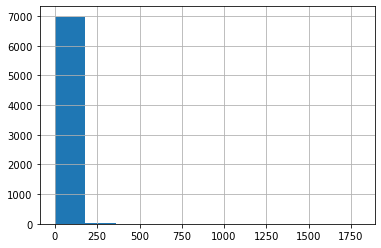

In [20]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count